# Eye tracking - Quantitative analysis

This part focuses on quantitative analysis on eye tracking data.

## Import and global variables

In [36]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import argrelextrema, argrelmax
from pylab import savefig

In [3]:
# Columns index - default export containing all elements
participant = 2
recording_name = 3
time_column = 8
gaze_x_column = 9
gaze_y_column = 10
pupil_diam_left = 32
pupil_diam_right = 33
mt_column = 34               # movement type column
md_column = 35               # movement duration column
mi_column = 36               # movement index column
event_column = 39            # Event type

# When using the short version of exported files
if True:
    participant = 0
    recording_name = 1
    recording_duration = 2      # can be useful?
    time_column = 3
    gaze_x_column = 4
    gaze_y_column = 5
    pupil_diam_left = 6
    pupil_diam_right = 7           
    mt_column = 8               # movement type column
    md_column = 9               # movement duration column
    mi_column = 10               # movement index column
    event_column = 11           # Event type

print participant

0


In [4]:
# Used to speed up the reading of the file by Pandas
eye_tracking_type = {
    'Project name': str,
    # 'Export date': str,
    'Recording name': str,
    'Participant name': int,
    # 'Recording start time': str
    'Recording duration': str,
    'Recording fixation filter name': str,
    'Recording timestamp': int,
    }

## Helper functions

In [5]:
def load(location):
    data = []

    # Parsing the file line by line and replacing errors if encountered.
    with open(location, 'rU') as f:
        csv_file = csv.reader(f, delimiter=';', quotechar='|')
        for line in csv_file:
            data.append(line)
    
    # Filtering the data where Eye Tracking is not working
    return [line for line in data if not line[mt_column] == "EyesNotFound"]

In [6]:
# Read UTF-16 encoded csv or tsv. Usefull considering cross-platform encoding. 

import codecs

def load_bis(location):
    data = []
    f=codecs.open(location,"rb","utf-16")
    csvread=csv.reader(f,delimiter='\t')
    csvread.next()
    for row in csvread:
        data.append(row)
    
    # Filtering the data where Eye Tracking is not working
    return [line for line in data if not line[mt_column] == "EyesNotFound"]  

In [7]:
def read(name):
    return pd.read_csv(name)

In [29]:
# tmp = load("/media/sf_EyeTracking/data/all_data_41_43.csv")
tmp = load_bis("/media/sf_EyeTracking/data/data.txt")
len(tmp)

1012670

In [30]:
def fixation_key(user):
    return "all " + str(float(user)) + ' - Fixation time (ms)'

def saccade_key(user):
    return "all " + str(float(user)) + ' - Saccade time (ms)'

def gaze_x_key(user):
    return "all " + str(float(user)) + ' - Gaze X (pixels)'

def gaze_y_key(user):
    return "all " + str(float(user)) + ' - Gaze Y (pixels)'

keys = {'fixation': fixation_key, 'saccade': saccade_key, 'gaze_x': gaze_x_key, 'gaze_y': gaze_y_key}


In [31]:
def quantitative(raw_data, user_id, type):
    raw_data = raw_data[1:]

    def analyse_records(data, user_id):
        # Fixation and saccade times
        pd1 = pd.DataFrame(list(set([float(line[md_column]) for line in data if line[mt_column] == "Fixation"])),
                           columns=[str(user_id) + ' - Fixation time (ms)']).describe(include='all')
        pd2 = pd.DataFrame(list(set([float(line[md_column]) for line in data if line[mt_column] == "Saccade"])),
                           columns=[str(user_id) + ' - Saccade time (ms)']).describe(include='all')

        # X and Y coordinates of gaze points
        pd3 = pd.DataFrame([float(line[gaze_x_column]) for line in data if is_number(line[gaze_x_column])],
                           columns=[str(user_id) + ' - Gaze X (pixels)']).describe(include='all')
        pd4 = pd.DataFrame([float(line[gaze_y_column]) for line in data if is_number(line[gaze_y_column])],
                           columns=[str(user_id) + ' - Gaze Y (pixels)']).describe(include='all')

        return pd.concat([pd1, pd2, pd3, pd4], axis=1)

    if type == "all":
        data = [line for line in raw_data if float(line[participant]) == user_id]
        return analyse_records(data, "all " + str(user_id))

    if type == "each":
        records = list(set([line[recording_name] for line in raw_data if float(line[participant]) == user_id]))
        records.sort()
        dfs = pd.DataFrame()
        for rec in records:
            data = [line for line in raw_data if line[recording_name] == rec]
            dfs = pd.concat([dfs, analyse_records(data, str(user_id) + " - " + str(rec))], axis=1)
        return dfs


In [69]:
def describe_quantitative(d, users, save=True):

    # Showing: fixation, saccade, gaze X, gaze Y on average
    f, axarr = plt.subplots(4, sharex=True)
    users_int = [int(user) for user in users]
    axarr[0].set_xlim([min(users_int)-1, max(users_int)+1])
    axarr[0].set_title("Average fixation time")
    axarr[0].set_ylabel("time (ms)")
    axarr[1].set_title("Average saccade time")
    axarr[1].set_ylabel("time (ms)")
    axarr[2].set_title("Average Gaze X position")
    axarr[2].set_ylim([0, 1920])
    axarr[2].set_ylabel("position (pixel)")
    axarr[3].set_title("Average Gaze Y position (not reversed)")
    axarr[3].set_ylim([0, 1080])
    axarr[3].set_ylabel("position (pixel)")

    def plot_describe(data_frame, pos):
        data_array = data_frame.as_matrix()
        for index in range(0, len(data_array[0])):
            axarr[pos].errorbar(int(users[index]), data_array[1][index], data_array[2][index], fmt='ok', 
                                color='red', lw=3)
            axarr[pos].errorbar(int(users[index]), data_array[1][index],
                         [[data_array[1][index] - data_array[3][index]], [data_array[7][index] - data_array[1][index]]],
                         fmt='.k', color='gray', lw=1)

    def plot_one_value(value, pos):
        data_frame = pd.DataFrame()
        for user in users:
            result = pd.concat([quantitative(d, float(user), "all"), quantitative(d, float(user), "each")], axis=1)

            # Saving the results into CSV
            if save is True:
                # base = os.path.dirname(os.path.abspath(__file__))
                # location = base + "\\..\\results\\" + str(user) + "_results.csv"
                location = str(user) + "_results.csv"
                result.to_csv(location, sep=';')

            key = keys[value](user)
            data_frame = pd.concat([data_frame, pd.DataFrame(result, columns=[key])], axis=1)
        plot_describe(data_frame, pos)

    plot_one_value('fixation', 0)
    plot_one_value('saccade', 1)
    plot_one_value('gaze_x', 2)
    plot_one_value('gaze_y', 3)
    plt.tight_layout()
    plt.xlabel('User ID')
    
    f.set_size_inches(20, 18, forward=True)
    
    # Save pictures
    savefig('foo.png', bbox_inches='tight')
    savefig('foo.pdf', bbox_inches='tight')
    
    # Show the curves
    plt.show()

In [70]:
def get_users(data):
    users = list(set([line[participant] for line in data[1:]]))
    users.sort()
    return users

In [71]:
def is_number(str):
    try:
        float(str)
        return True
    except:
        return False

## Quantitative analysis - based on standard deviation

In [72]:
# Getting the list of users
users = get_users(tmp)

print "List of users: " + str(users)

List of users: ['11', '12', '13', '14', '15', '16', '17', '18', '2', '20', '21', '22', '23', '24', '25', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '4', '5', '6', '7', '8', '9']


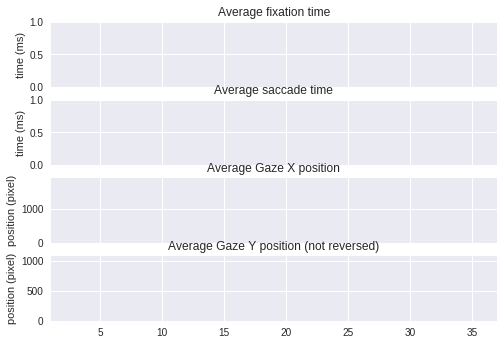

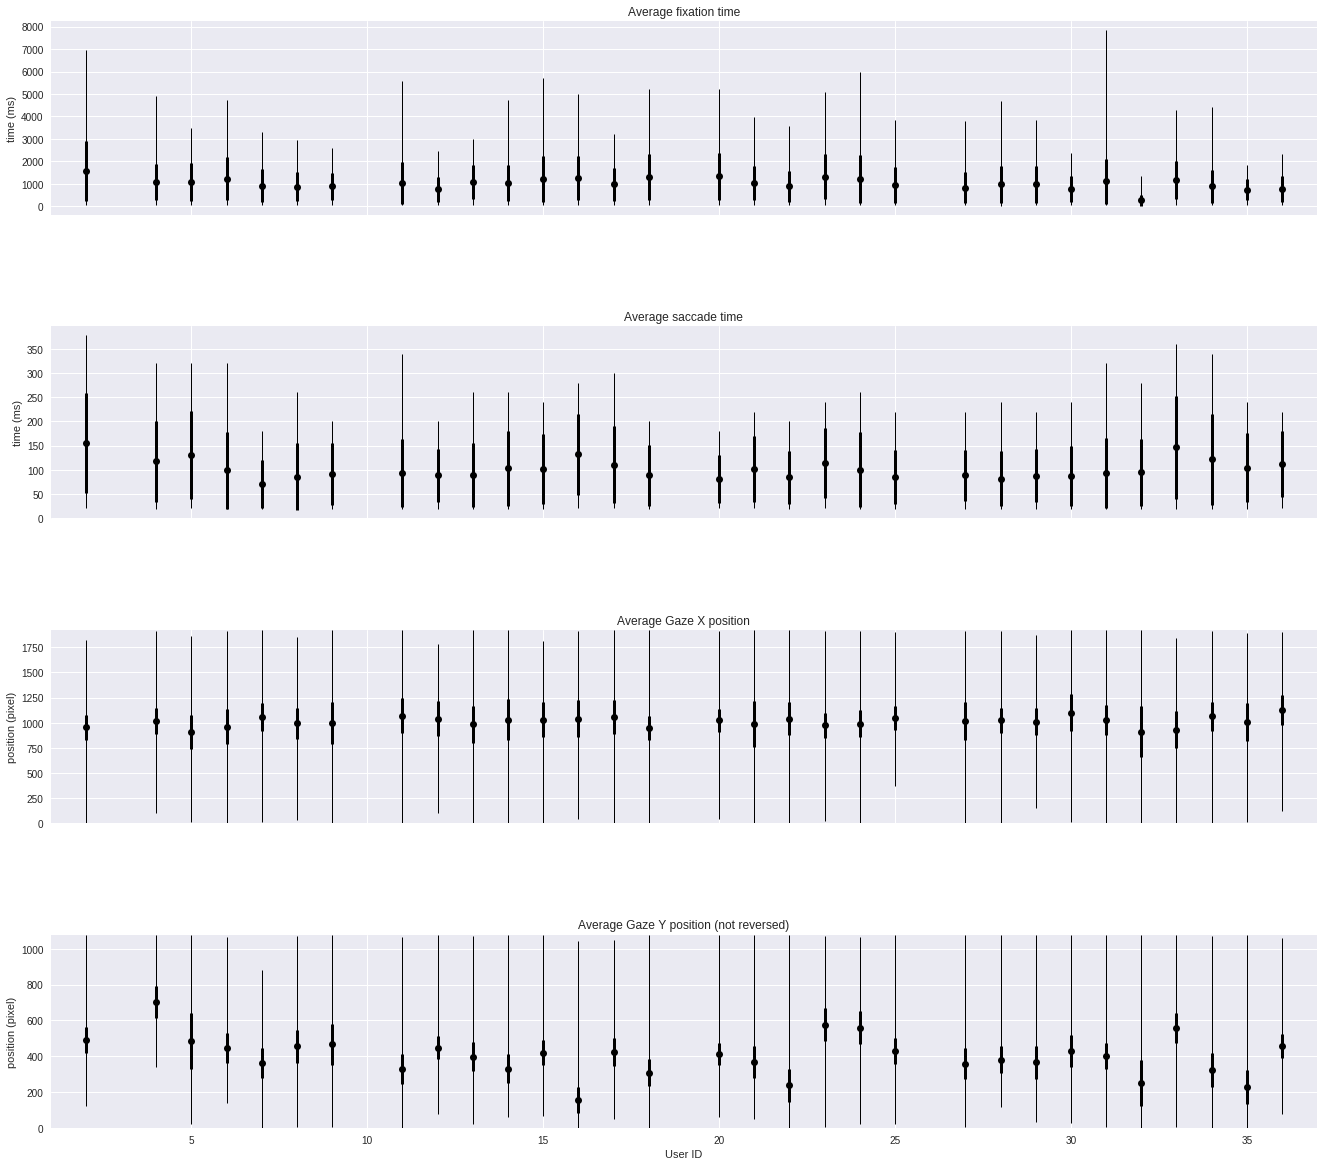

In [73]:
describe_quantitative(tmp, users, save=True)

## Analysing gaze points over X and Y coordinates

### X coordinates: working over value distribution

In [75]:
# Selecting the values for one user and one recording.
x_pos = [line[gaze_x_column] for line in tmp 
            if line[participant] == '42' 
            and line[recording_name] == 'Recording172']
x_pos = [int(line) for line in x_pos if line != '']
x_pos = np.asarray(x_pos)

print "List of x values: " + str(x_pos)

List of x values: [ 979  981  982 ..., 1276 1278 1280]


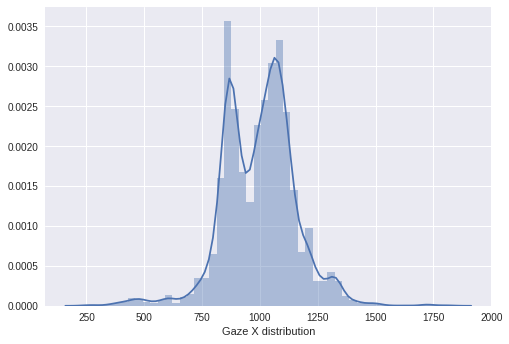

In [76]:
# Plotting the distribution based on SeaBorn
x_pos = pd.Series(x_pos, name="Gaze X distribution")
x_dist = sns.distplot(x_pos)
plt.show()

This represents where people look at when driving. They mostly look at their lane, but also check the opposite one, which is more on the left. 

It is then interesting to have a look at the distance between the two peaks (at first counted here, in number of bins - arbitrary value, stable over measurement). The ratio between the first and second extrema is then computed. 

Some curves might create other extremum that are not related to the driving lanes, this can then be corrected manually by choosing the right extremum.

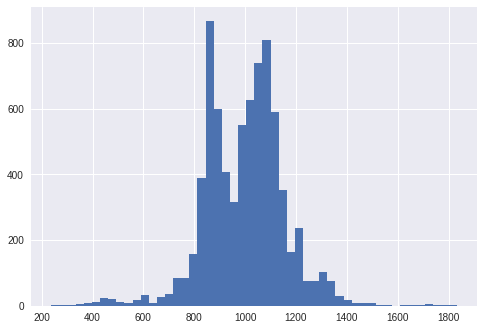

In [17]:
# Reconstructing the values based on NumPy
a = x_pos.hist(bins=50)
plt.show()

In [28]:
def get_hist(ax):
    n, bins = [],[]
    for rect in ax.patches:
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        n.append(y1-y0)
        bins.append(x0) # left edge of each bin
    bins.append(x1) # also get right edge of last bin

    return n,bins

n, bins = get_hist(a)
n = np.asarray(n)

def bin_length(bins):
    bin_len = []
    for i in range(0,len(bins)-1):
        bin_len.append(bins[i + 1] - bins[i])
    return bin_len

bin_len = bin_length(bins)
bin_length = bin_len[0]

In [32]:
n_values = n[argrelmax(n)[0]]
print "Local optimums values: " + str(n_values)

# Return maximum
fst_max = np.partition(n_values.flatten(), -1)[-1]
fst_index = np.argmax(n)
print "First extremum: " + str(fst_index) + ", " + str(fst_max)

# Return second value
scd_max = np.partition(n_values.flatten(), -2)[-2]
scd_index = np.nonzero(n==scd_max)[0][0]
print "Second extremum: " + str(scd_index) + ", " + str(scd_max)

diff_max = fst_max - scd_max
diff_index = fst_index - scd_index
print "Difference between optimums positions: " + str(diff_index) + " bins"
print "Difference between optimums position: " + str(diff_index * bin_length) + " pxls"
print "Difference between optimums value: " + str(diff_max) + " pxls"
print "Ratio between optimums: " + str(fst_max/scd_max)


Local optimums values: [   3.   25.   34.  866.  808.  236.  104.   10.    6.]
First extremum: 19, 866.0
Second extremum: 26, 808.0
Difference between optimums positions: -7 bins
Difference between optimums position: -223.44 pxls
Difference between optimums value: 58.0 pxls
Ratio between optimums: 1.07178217822


Results on participant 42:
- recording 169:  5,   456.0   (tr2)
- recording 170:  5,   296.0   (tr3)
- recording 171:  7,   573.0   (tr1)
- recording 172: -7,    58.0   1.071  (tr2)

Results on participant 43:
- recording 173:  5,   419.0   1.570  (tr3)
- recording 175: -2,   149.0,  1.198  (tr1)
- recording 176: -4,   262.0,  1.287  (tr2)
- recording 177:  5,   262.0,  1.420  (tr3)

### X coordinates: working over time distribution

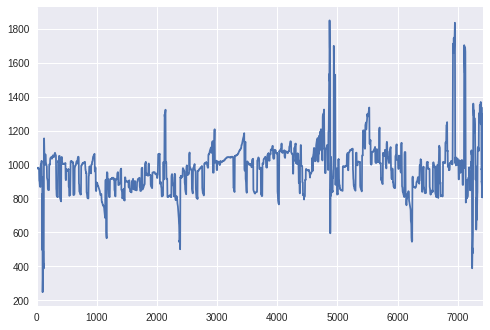

In [21]:
# Printing with SeaBorn
sns.tsplot(x_pos)
plt.show()

First one might represent looking in the side mirror when starting. Other ones might also represent crossing or checking on the sides. 

### Y coordinates: working over value distribution

In [25]:
# Getting the data for one user and one record
y_pos = [line[gaze_y_column] for line in tmp 
         if line[participant] == '42' 
         and line[recording_name] == 'Recording169']
y_pos = [int(line) for line in y_pos if line != '']

# Reversing the data
y_pos = [1080 - line for line in y_pos]
y_pos = np.asarray(y_pos)
y_pos

array([807, 808, 809, ..., 906, 702, 474])

In [26]:
recordings = list(set([line[recording_name] for line in tmp]))
recordings

['Recording164',
 'Recording177',
 'Recording175',
 'Recording name',
 'Recording176',
 'Recording166',
 'Recording167',
 'Recording173',
 'Recording172',
 'Recording171',
 'Recording170',
 'Recording168',
 'Recording169']

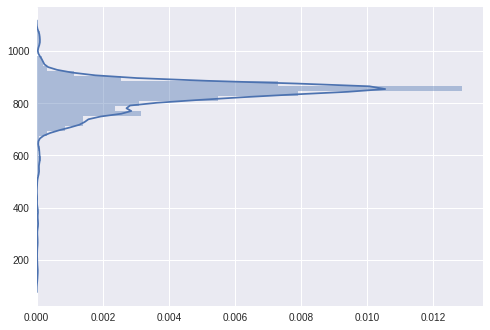

In [27]:
sns.distplot(y_pos, vertical=True, name="Gaze Y distribution")
plt.show()

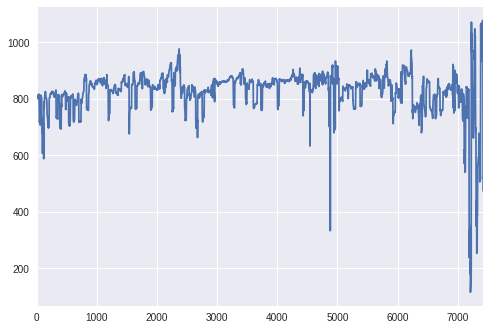

In [18]:
sns.tsplot(y_pos)
plt.show()

Peaks show the number of time the driver is checking the upper mirror. Down shows the checking of commands (biggest ones) or of the speed indication (less big ones). 